# Data Preparation
### Training a Neural Network to identify the best M3 Combo
By Zach Shelton
5/13/21


In [1]:
#NanoAOD HackSchema
#Solution from Danny Noonan

In [235]:
from __future__ import print_function, division
import uproot
import numpy as np
#Make sure to install both old awkward0 and new awkward1(referred to now as awkward)
import awkward1 as ak
import awkward0 as ak0
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
import coffea
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import coffea.hist as hist
import matplotlib.pyplot as plt
import awkward
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
from pprint import pprint

## Note: It seems the Jet columns are sorted from greatest p_t to smallest p_t
Feel free to test, but it seems to be my observation, choosing the 1st, 2nd or 3rd jet via index should remove the issue of it being a coffea sorting artifact or procedure

In [381]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events =NanoEventsFactory.from_root(files,schemaclass=HackSchema,entry_stop=500).events()

In [382]:
#Condensing_all Lepton_cuts
jets=events.Jet
jetSel = (jets.pt>30) & (abs(jets.eta)<2.4)
tightJet = jets[jetSel]
bJet = tightJet[tightJet.btagDeepFlavB > 0.642]
muons = events.Muon
muonSel = (muons.pt>30) & (abs(muons.eta)<2.4)
tightMuon = muons[muonSel]
ele = events.Electron
eleSel = (ele.pt>35)&(abs(ele.eta)<2.4)
tightEle = ele[eleSel]
eventSel = (((ak.num(tightMuon)==1) | (ak.num(tightEle)==1)) &
            (ak.num(tightJet)>= 3) & (ak.num(bJet)>=1)
           )
final = events[eventSel]

In [383]:
#G = Global index of particles - Artifact from Coffea/NanoAOD Tools
print(len(final))

308


In [384]:
genPart = events.GenPart
tops = genPart[abs(genPart.pdgId)==6]
tops = tops[tops.hasFlags('isLastCopy')]
tDecay = tops.distinctChildren
tDecay = tDecay[tDecay.hasFlags('isLastCopy')]
t_Events=tDecay[abs(tDecay.pdgId)==5]
W = tDecay[abs(tDecay.pdgId)==24]
W = W[W.hasFlags('isLastCopy')]
WDecay = W.distinctChildren
WDecay = WDecay[WDecay.hasFlags('isLastCopy')]
#t_events is the lone bottom, W_events is the -> two jets
W_Events=ak.flatten(WDecay[ak.all(abs(WDecay.pdgId)<=8,axis=-1)],axis=3)
#select the hadronically decaying W
hadW = ak.num(W_Events,axis=2)==2
#select b quarks associated with hadronically decaying W
hadB = t_Events[hadW]
hadB = ak.flatten(hadB,axis=2)
W_quarks = W_Events[hadW]
W_quarks = ak.flatten(W_quarks,axis=2)
qqb = ak.concatenate([hadB,W_quarks],axis=1)
print(qqb)
print(qqb.pdgId)

[[GenParticle, GenParticle, GenParticle], ... GenParticle, GenParticle, GenParticle]]
[[5, 2, -1], [5, 4, -3], [-5, 1, -2], [-5, ... [5, 2, -1], [5, 2, -1], [5, 4, -3]]


In [385]:
print(W_quarks)

[[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]


In [386]:
#Process for determining correct jets.
#match Tightjets with nearest.
#Take the sum of the combinations and compare the transverse momenta of them.

In [387]:
combs=ak.combinations(tightJet,3)
argcomb=ak.argcombinations(tightJet,3)
matchevents=qqb.nearest(tightJet,axis=1)

In [388]:
print(matchevents.sum().pt)
#print(ak.sum(matchevents,axis=-1))

[138, 142, 150, 179, 155, 87.8, 62.6, 318, ... 130, 169, 78.2, 196, 85.5, 32.3, 13]


In [389]:
vals=ak.ArrayBuilder()
n=0
pt_sum=matchevents.sum().pt
while(n<len(events)):
    c=combs[n]
    test_sum=c['0']+c['1']+c['2']
    event_vals=(test_sum.pt==pt_sum[n])
    vals.append(event_vals)
    n+=1
comb_truths=ak.flatten(vals)
combinations=ak.flatten(combs)

In [390]:
print(len(comb_truths))
print((combinations))

4588
[(Jet, Jet, Jet), (Jet, Jet, Jet), (Jet, Jet, ... Jet, Jet, Jet), (Jet, Jet, Jet)]


In [372]:
#The values are in tuples, but can be solved with a concatenate

In [373]:
from matplotlib import pyplot as plt 

In [391]:
good_vals=combinations[comb_truths]
bad_vals=combinations[np.invert(comb_truths)]

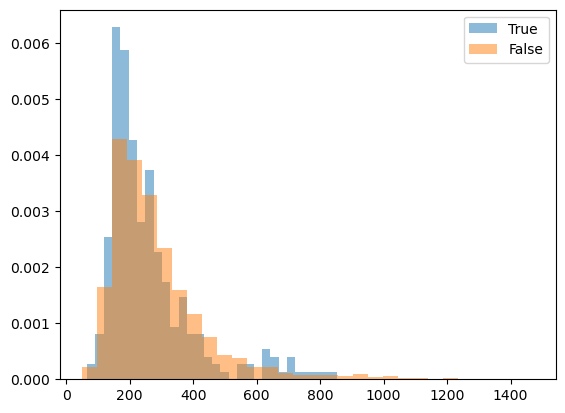

In [398]:
greco=good_vals['0']+good_vals['1']+good_vals['2']
breco=bad_vals['0']+bad_vals['1']+bad_vals['2']
plt.hist(greco.mass,bins=30,alpha=.5,density=True)
plt.hist(breco.mass,bins=30,alpha=.5,density=True)
plt.legend(["True","False"])
plt.show()

______________________________________________________________________________
# Running Notes and questions
- Losing Data because of arbitrary 8 jet cut?

## Notes for Zach to keep up

Wrap into Coffea Executor!!!!!!!!!!!!

Seperate values, weights and triggers(X)
read these into tensors for Keras(X)
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch

## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable